In [177]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

In [119]:
# load data from 2 csv into 2 df
df1 = pd.read_csv("data/2015.csv")
df2 = pd.read_csv("data/2017.csv")

In [120]:
# join the 2 df into 1
resale_price = pd.concat([df1, df2], ignore_index=True)

In [122]:
# convert the month column to monthly period
resale_price["month"] = pd.to_datetime(resale_price["month"]).dt.to_period('M')

In [123]:
# sort by month in ascending order
resale_price.sort_values("month", inplace=True)

In [ ]:
# filter out 4 room resale flats in queenstown from 2014-01 to 2024-12
start = "2014-01"
end = "2024-12"

resale_price_10y = resale_price[
    (resale_price["month"] >= start) &
    (resale_price["month"] <= end) &
    (resale_price["flat_type"] == "4 ROOM") &
    (resale_price["town"] == "QUEENSTOWN")
]

In [125]:
# create the time series data
resale_price_10y = resale_price_10y.iloc[:, [0, -1]].groupby("month").mean()
resale_price_10y.rename(columns={'resale_price': 'avg_resale_price'}, inplace=True)

In [126]:
resale_price_10y

,avg_resale_price
month,
2015-01,658626.181818
2015-02,677173.500000
2015-03,654454.545455
2015-04,629500.000000
2015-05,636990.000000
...,...
2024-08,924008.631579
2024-09,893834.857143
2024-10,881703.619048


In [127]:
warnings.filterwarnings('ignore')

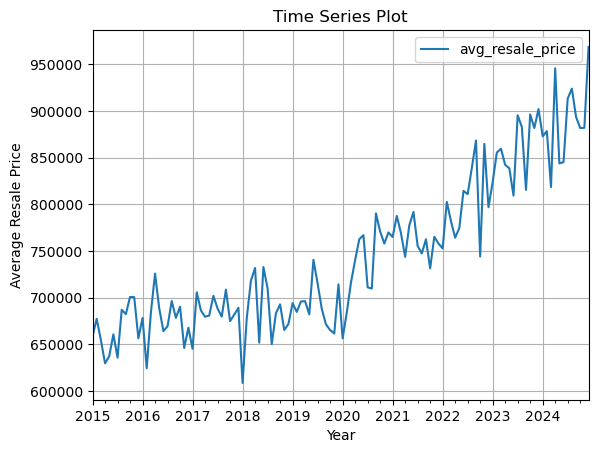

In [128]:
# time series plot
resale_price_10y.plot()
plt.title('Time Series Plot')
plt.xlabel('Year')
plt.ylabel("Average Resale Price")
plt.grid(True)
plt.show()

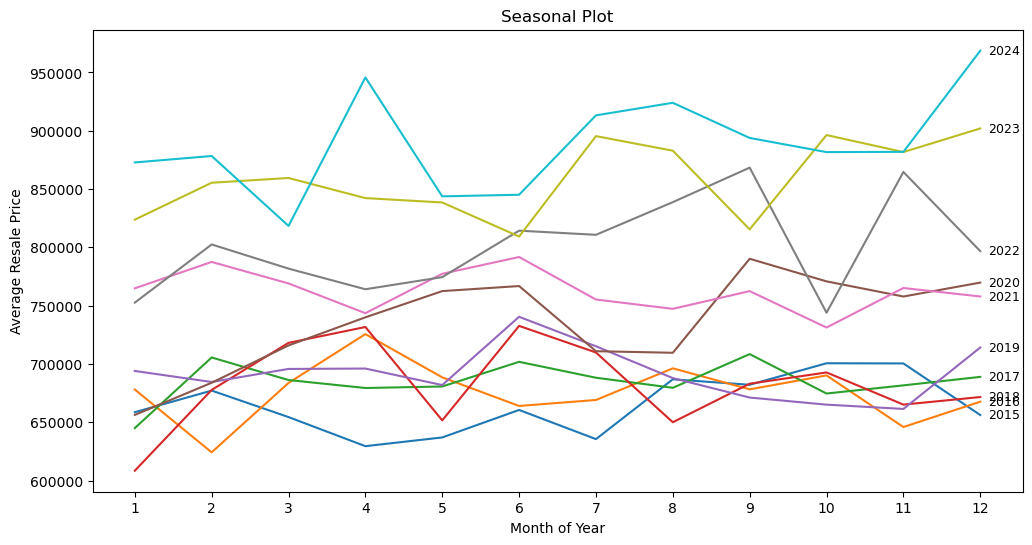

In [131]:
# seasonal plot
years = resale_price_10y.index.year.unique()

plt.figure(figsize=(12, 6))

for year in years:
    data = resale_price_10y[resale_price_10y.index.year == year]
    months = data.index.month
    values = data.values
    plt.plot(months, values, label=year)
    if len(months) > 0:
        plt.text(months[-1] + 0.1, values[-1], str(year), fontsize=9, verticalalignment='center')

plt.title('Seasonal Plot')
plt.xlabel('Month of Year')
plt.xticks(range(1, 13))
plt.ylabel("Average Resale Price")
plt.show()

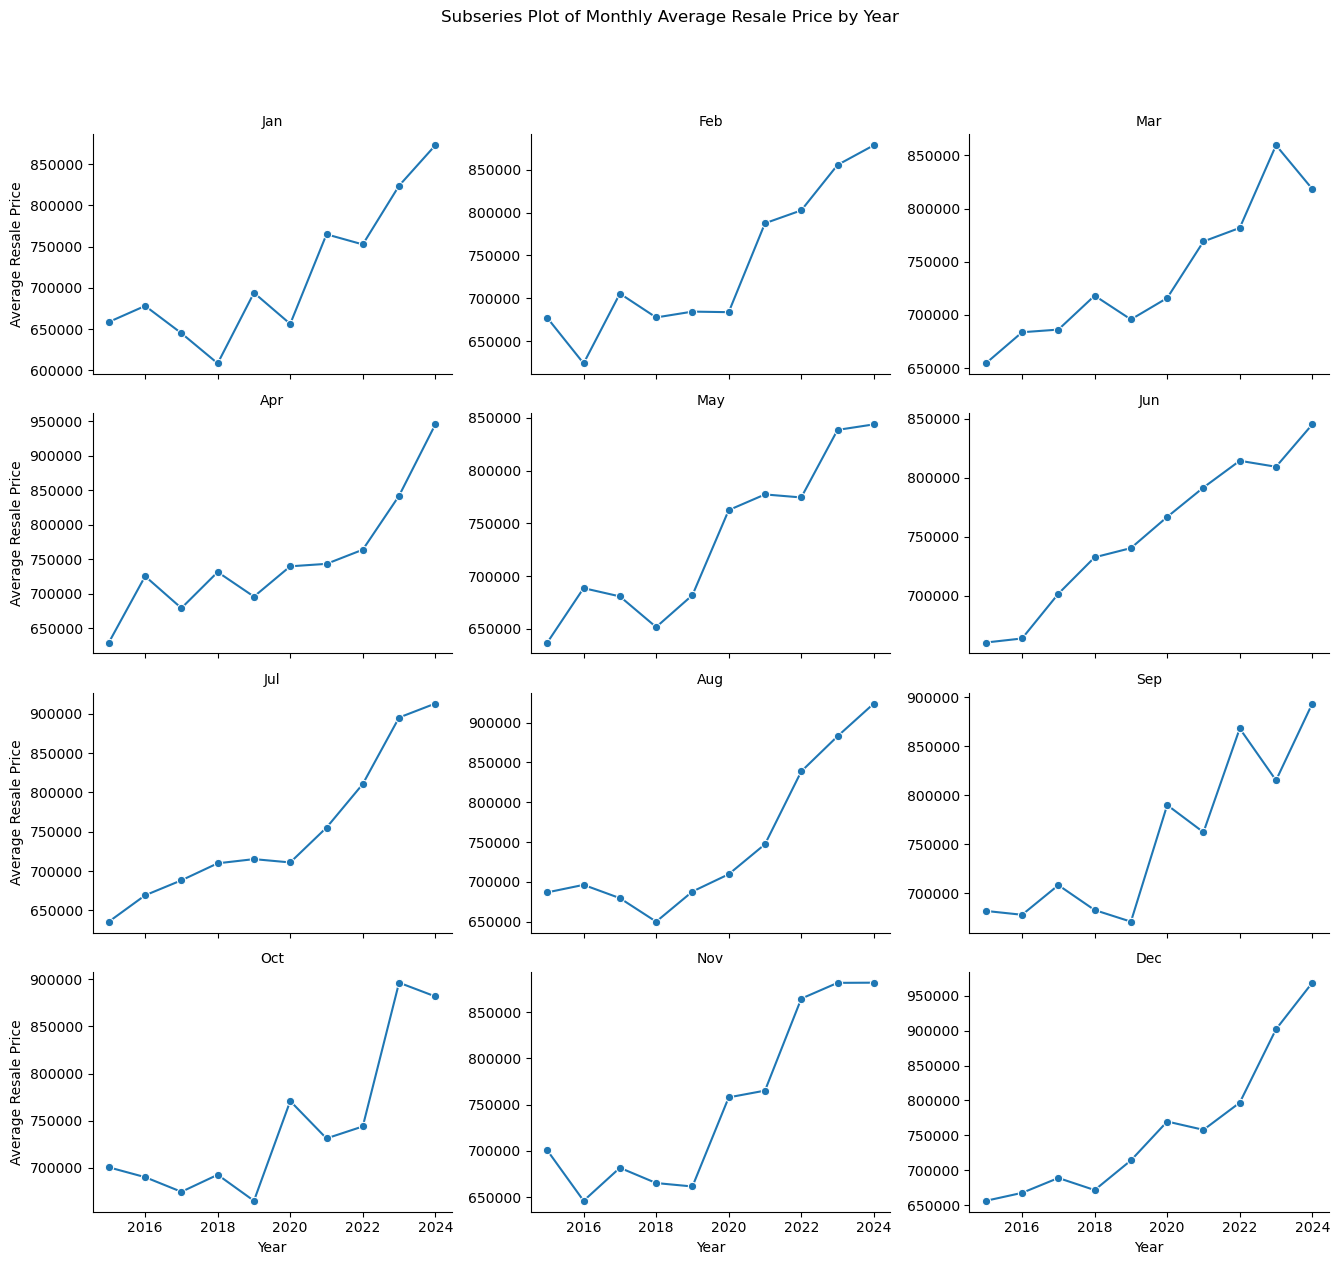

In [136]:
# subseries plot
dates = resale_price_10y.index.astype('datetime64')
data_df = resale_price_10y.reset_index('month')
data_df['month'] = dates.strftime('%b')
data_df['year'] = dates.year.astype(int)

g = sns.FacetGrid(data_df, col="month", col_wrap=3, height=3, aspect=1.5, sharey=False)
g.map(sns.lineplot, "year", "avg_resale_price", marker='o')
g.set_axis_labels('Year', 'Average Resale Price')
g.set_titles("{col_name}")
g.fig.suptitle('Subseries Plot of Monthly Average Resale Price by Year', y=1.05)
g.tight_layout()

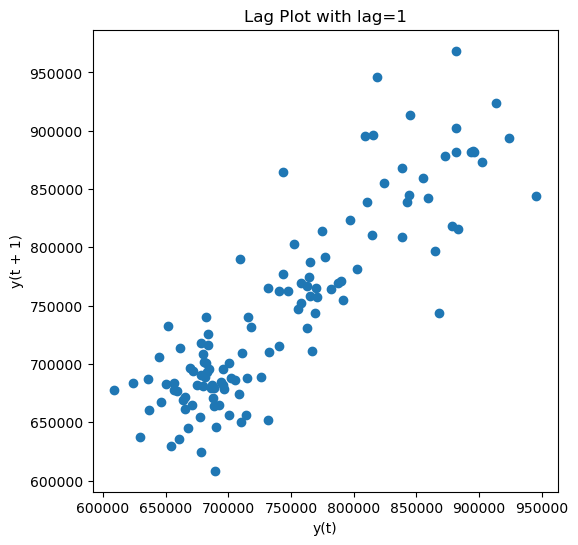

In [138]:
# lag plot
plt.figure(figsize=(6, 6))
lag_plot(resale_price_10y, lag=1)
plt.title('Lag Plot with lag=1')
plt.show()

<Figure size 1200x600 with 0 Axes>

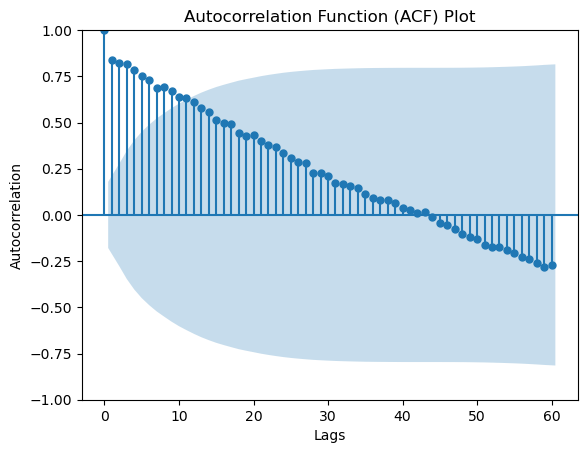

In [153]:
# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(resale_price_10y, lags=60, alpha=0.05)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

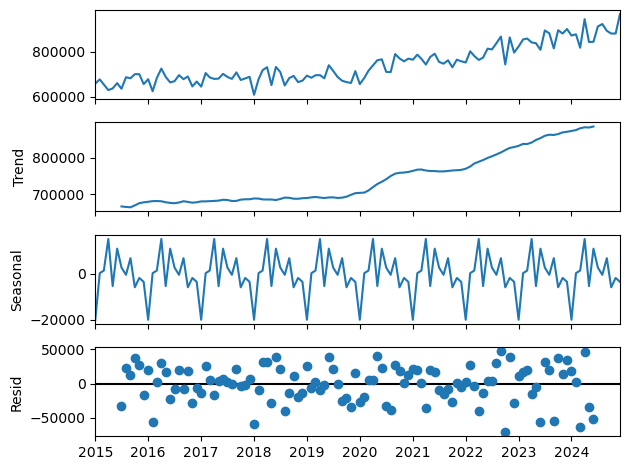

In [148]:
# addictive decomposition
resale_price_10y.index = dates

decomposition = seasonal_decompose(resale_price_10y, model='additive')

fig = decomposition.plot()
plt.show()

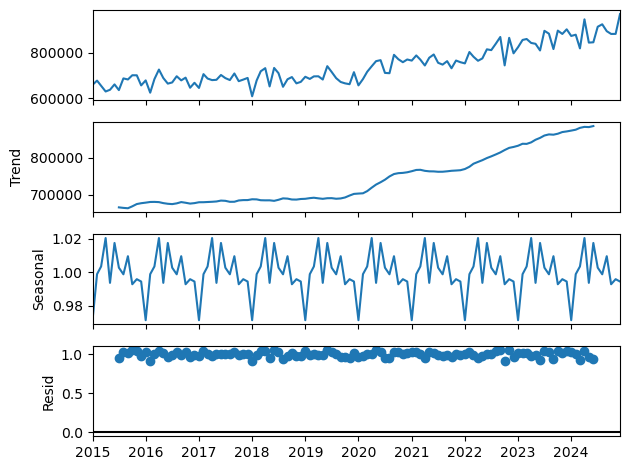

In [149]:
# multiplicative decomposition
decomposition = seasonal_decompose(resale_price_10y, model='multiplicative')

fig = decomposition.plot()
plt.show()

In [163]:
# convert index to Period[M]
resale_price_10y.index = resale_price_10y.index.to_period('M')

In [171]:
# initialsie test and train set
y_train, y_test = temporal_train_test_split(resale_price_10y, test_size=12)

In [173]:
# Define the forecasting horizon
fh = np.arange(1, len(y_test) + 1)

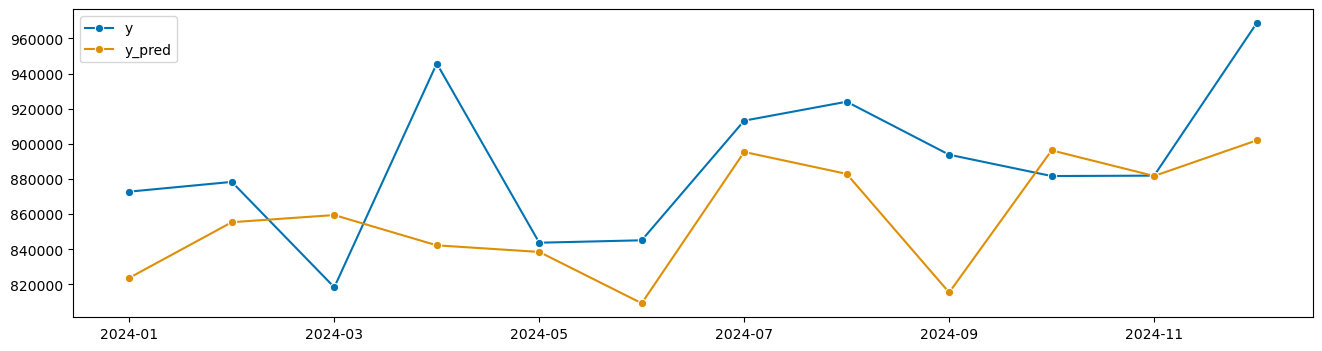

In [174]:
# seasonal naive forcasting
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=fh)

plot_series(y_test, y_pred, labels=["y", "y_pred"])

smape_naive = mean_absolute_percentage_error(y_test, y_pred, symmetric=True)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

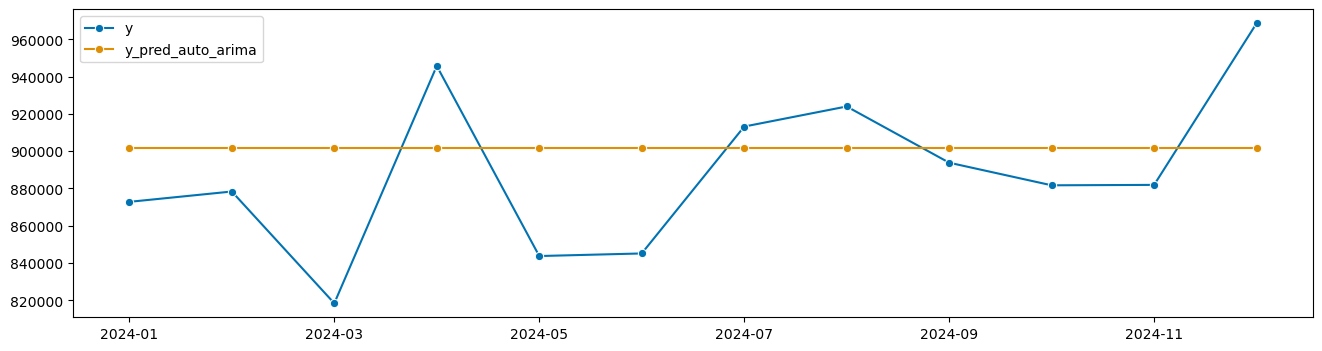

In [178]:
# auto ARIMA
auto_arima_model = AutoARIMA(sp=12, suppress_warnings=True, stepwise=True)

auto_arima_model.fit(y_train)

y_pred_auto_arima = auto_arima_model.predict(fh=fh)

smape_auto_arima = mean_absolute_percentage_error(y_test, y_pred_auto_arima, symmetric=True)

plot_series(y_test, y_pred_auto_arima, labels=["y", "y_pred_auto_arima"])

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

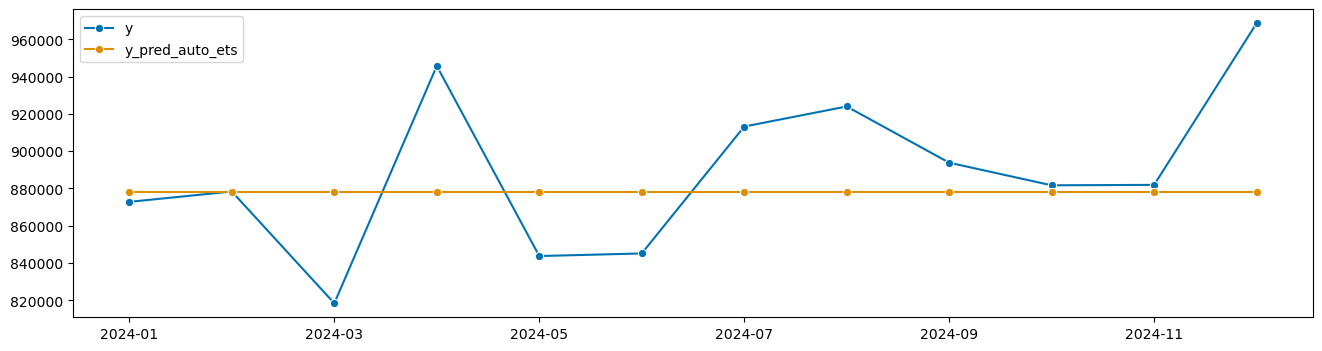

In [179]:
# auto ETS
auto_ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)

auto_ets_model.fit(y_train)

y_pred_auto_ets = auto_ets_model.predict(fh=fh)

smape_auto_ets = mean_absolute_percentage_error(y_test, y_pred_auto_ets, symmetric=True)

plot_series(y_test, y_pred_auto_ets, labels=["y", "y_pred_auto_ets"])

In [180]:
print(f'sMAPE (Seasonal Naive Forcasting): {smape_naive:.3f}')
print(f'sMAPE (AutoARIMA): {smape_auto_arima:.3f}')
print(f'sMAPE (AutoETS): {smape_auto_ets:.3f}')

sMAPE (Seasonal Naive Forcasting): 0.045
sMAPE (AutoARIMA): 0.041
sMAPE (AutoETS): 0.037
